H vs (E and S)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 29.6 MB/s eta 0:00:00


No optimiser

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 333ms/step - accuracy: 0.5366 - loss: 38.9148 - val_accuracy: 0.6333 - val_loss: 0.5900
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - accuracy: 0.5254 - loss: 2.1069 - val_accuracy: 0.6111 - val_loss: 3.5675
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.7291 - loss: 1.2461 - val_accuracy: 0.6111 - val_loss: 0.5807
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step - accuracy: 0.7374 - loss: 0.4869 - val_accuracy: 0.6111 - val_loss: 0.7186
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - accuracy: 0.6378 - loss: 0.6276 - val_accuracy: 0.6111 - val_loss: 1.3483
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - accuracy: 0.7914 - loss: 0.4766 - val_accuracy: 0.6556 - val_loss: 0.6052
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 637ms/step - accuracy: 0.6263 - loss: 0.5725 - val_accuracy: 0.6111 - val_loss: 0.9515
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 453ms/step - accuracy: 0.7112 - loss: 0.5583 - val_accuracy: 0.6111 - val_loss

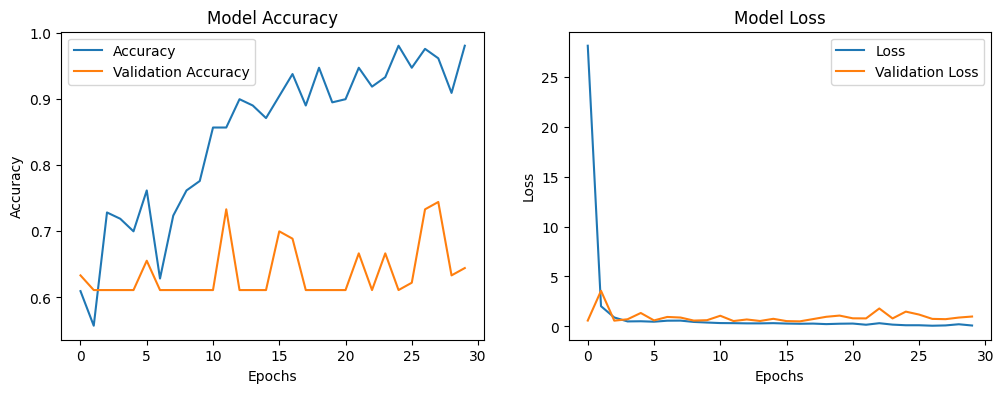

Training time: 97.81 seconds
Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN/Exp4/No_Options.keras ✅


In [3]:
# Import necessary libraries
import os
import numpy as np
import pywt
import pywt.data
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import time  # To measure training time

# Function to load data from a directory
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function to apply wavelet decomposition
def apply_wavelet_decomposition(data, wavelet='db4', level=5):
    coeffs = []
    for signal in data:
        # Perform wavelet decomposition
        wavelet_coeffs = pywt.wavedec(signal, wavelet, level=level)
        # Get approximation coefficients at level 5 and detail coefficients
        coeffs.append(wavelet_coeffs[-1])  # Only use the last level of detail coefficients
    return np.array(coeffs)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Healthy
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Seizure
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # Epileptic

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (label 0)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=1)  # Seizure (label 1)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (label 1)

# Combine data and labels for Healthy vs (Seizure + Epileptic)
if data_Healthy.size > 0 and (data_Seizure.size > 0 or data_Epileptic.size > 0):
    data_all = np.concatenate((data_Healthy, data_Seizure, data_Epileptic), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Seizure, labels_Epileptic), axis=0)

    # Apply wavelet decomposition to the data
    data_all_wavelet = apply_wavelet_decomposition(data_all, wavelet='db4', level=5)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all_wavelet, labels_all, test_size=0.3, random_state=42)

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (0 for Healthy, 1 for Seizure/Epileptic)
    ])

    # Compile the model without specifying an optimizer (using default behavior)
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])

    # Measure the training time
    start_time = time.time()

    # Train the model
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    # Calculate the time taken for training
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds")

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")



      # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp4/No_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


with standarisation

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.7085 - loss: 0.5899 - val_accuracy: 0.6111 - val_loss: 0.6787
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7046 - loss: 0.4362 - val_accuracy: 0.6111 - val_loss: 0.5425
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6752 - loss: 0.4584 - val_accuracy: 0.6667 - val_loss: 0.4723
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7767 - loss: 0.3976 - val_accuracy: 0.7778 - val_loss: 0.4293
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8613 - loss: 0.2784 - val_accuracy: 0.7333 - val_loss: 0.4915
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7727 - loss: 0.3927 - val_accuracy: 0.7556 - val_loss: 0.3906
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8618 - loss: 0.2901 - val_accuracy: 0.7111 - val_loss: 0.4283
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8339 - loss: 0.3074 - val_accuracy: 0.7778 - val_loss: 0.3795
Epoch 9/30


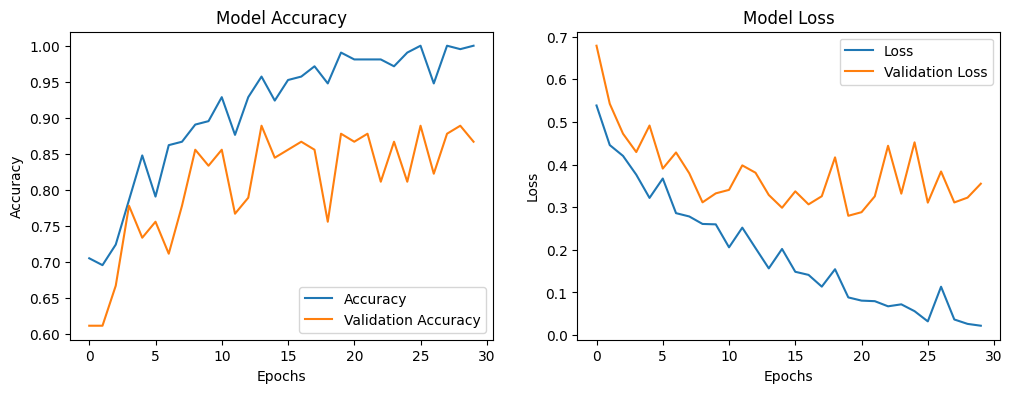

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN/Exp4/With_Stander.keras ✅


In [4]:
# Import necessary libraries
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import pywt  # For wavelet transform
import time  # To calculate training time

# Function to load data from a directory
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function to apply wavelet transform (db4, level 5)
def apply_wavelet_transform(data, wavelet='db4', level=5):
    transformed_data = []

    for signal in data:
        # Perform the wavelet decomposition
        coeffs = pywt.wavedec(signal, wavelet, level=level)

        # Reconstruct the signal using approximation coefficients and detailed coefficients
        # We keep only the approximation coefficients for the next step
        approx_coeffs = coeffs[0]  # Approximation at level 5

        transformed_data.append(approx_coeffs)

    return np.array(transformed_data)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Healthy
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Seizure
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # Epileptic

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (label 0)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=1)  # Seizure (label 1)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (label 1)

# Combine data and labels for Healthy vs (Seizure + Epileptic)
if data_Healthy.size > 0 and (data_Seizure.size > 0 or data_Epileptic.size > 0):
    data_all = np.concatenate((data_Healthy, data_Seizure, data_Epileptic), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Seizure, labels_Epileptic), axis=0)

    # Apply wavelet transform (db4, level 5) to the data
    data_all_wavelet = apply_wavelet_transform(data_all, wavelet='db4', level=5)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all_wavelet, labels_all, test_size=0.3, random_state=42)

    # Standardize the data using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape the data to fit the CNN model (1D input)
    X_train_scaled = X_train_scaled[..., np.newaxis]
    X_test_scaled = X_test_scaled[..., np.newaxis]

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (0 for Healthy, 1 for Seizure/Epileptic)
    ])

    # Compile the model without specifying an optimizer (using default behavior)
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])

    # Start timing the training process
    start_time = time.time()

    # Train the model
    history = model.fit(X_train_scaled, y_train, epochs=30, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=1)

    # Stop timing the training process
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate the model
    y_pred = model.predict(X_test_scaled)
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Print the training time
    print(f"\nTraining Time: {training_time:.2f} seconds")

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


        # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp4/With_Stander.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


with Optimiser

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.6592 - loss: 20.0888 - val_accuracy: 0.7222 - val_loss: 3.7066
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7194 - loss: 14.8561 - val_accuracy: 0.8000 - val_loss: 2.0576
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7467 - loss: 3.6751 - val_accuracy: 0.8333 - val_loss: 1.0425
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7691 - loss: 2.7512 - val_accuracy: 0.7111 - val_loss: 2.3556
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7872 - loss: 1.1689 - val_accuracy: 0.8444 - val_loss: 0.5799
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8167 - loss: 0.7744 - val_accuracy: 0.8111 - val_loss: 0.8014
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8333 - loss: 0.4711 - val_accuracy: 0.7778 - val_loss: 0.5074
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8891 - loss: 0.3333 - val_accuracy: 0.7333 - val_loss: 0.5621
Epoch 9/3

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Final Evaluation Metrics:
Test Accuracy:  0.8777777777777778
Test Recall (Sensitivity):  0.9636363636363636
Test Precision:  0.8548387096774194
Test Specificity:  0.7428571428571429
Confusion Matrix: 
 [[26  9]
 [ 2 53]]

Training Time: 12.61 seconds


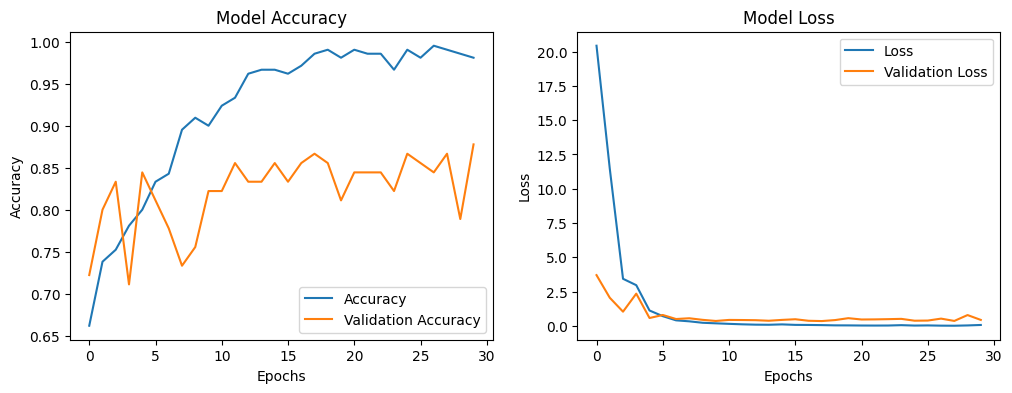

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN/Exp4/With_Optimiser.keras ✅


In [5]:
# Import necessary libraries
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import pywt  # For wavelet transform
import time  # To calculate training time

# Function to load data from a directory
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function to apply wavelet transform (db4, level 5)
def apply_wavelet_transform(data, wavelet='db4', level=5):
    transformed_data = []

    for signal in data:
        # Perform the wavelet decomposition
        coeffs = pywt.wavedec(signal, wavelet, level=level)

        # Reconstruct the signal using approximation coefficients and detailed coefficients
        # We keep only the approximation coefficients for the next step
        approx_coeffs = coeffs[0]  # Approximation at level 5

        transformed_data.append(approx_coeffs)

    return np.array(transformed_data)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Healthy
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Seizure
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # Epileptic

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (label 0)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=1)  # Seizure (label 1)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (label 1)

# Combine data and labels for Healthy vs (Seizure + Epileptic)
if data_Healthy.size > 0 and (data_Seizure.size > 0 or data_Epileptic.size > 0):
    data_all = np.concatenate((data_Healthy, data_Seizure, data_Epileptic), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Seizure, labels_Epileptic), axis=0)

    # Apply wavelet transform (db4, level 5) to the data
    data_all_wavelet = apply_wavelet_transform(data_all, wavelet='db4', level=5)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all_wavelet, labels_all, test_size=0.3, random_state=42)

    # Reshape the data to fit the CNN model (1D input)
    X_train_scaled = X_train[..., np.newaxis]
    X_test_scaled = X_test[..., np.newaxis]

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (0 for Healthy, 1 for Seizure/Epileptic)
    ])

    # Compile the model with the Adam optimizer
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Start timing the training process
    start_time = time.time()

    # Train the model
    history = model.fit(X_train_scaled, y_train, epochs=30, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=1)

    # Stop timing the training process
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate the model
    y_pred = model.predict(X_test_scaled)
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Print the training time
    print(f"\nTraining Time: {training_time:.2f} seconds")

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")



     # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp4/With_Optimiser.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")



with both optoimiser and standarisation

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.6147 - loss: 0.5870 - val_accuracy: 0.6111 - val_loss: 0.6062
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7017 - loss: 0.4765 - val_accuracy: 0.6111 - val_loss: 0.5767
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6954 - loss: 0.4721 - val_accuracy: 0.6111 - val_loss: 0.5552
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6645 - loss: 0.4526 - val_accuracy: 0.6111 - val_loss: 0.5065
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7217 - loss: 0.3703 - val_accuracy: 0.7000 - val_loss: 0.4642
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7819 - loss: 0.3703 - val_accuracy: 0.7222 - val_loss: 0.4287
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7606 - loss: 0.3457 - val_accuracy: 0.8889 - val_loss: 0.3936
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8968 - loss: 0.3158 - val_accuracy: 0.8111 - val_loss: 0.3811
Epoch 9/30


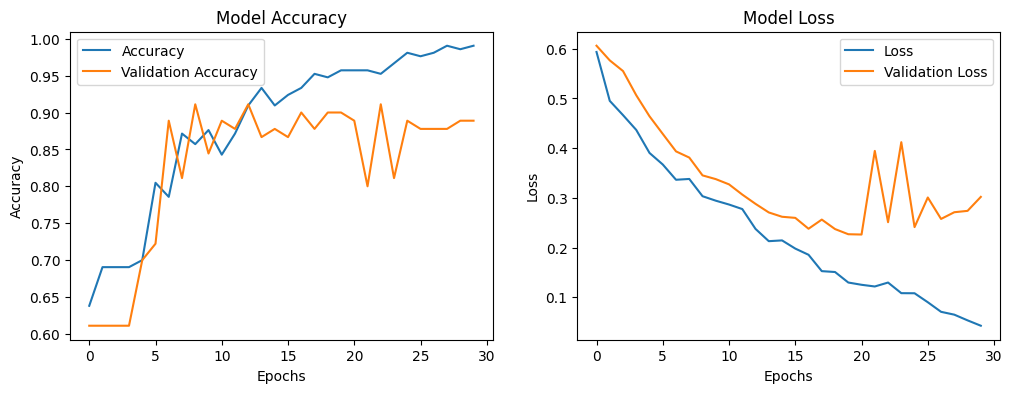

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN/Exp4/With_Options.keras ✅


In [6]:
# Import necessary libraries
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pywt  # For wavelet transform
import time  # To calculate training time

# Function to load data from a directory
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function to apply wavelet transform (db4, level 5)
def apply_wavelet_transform(data, wavelet='db4', level=5):
    transformed_data = []

    for signal in data:
        # Perform the wavelet decomposition
        coeffs = pywt.wavedec(signal, wavelet, level=level)

        # Reconstruct the signal using approximation coefficients and detailed coefficients
        # We keep only the approximation coefficients for the next step
        approx_coeffs = coeffs[0]  # Approximation at level 5

        transformed_data.append(approx_coeffs)

    return np.array(transformed_data)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Healthy
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Seizure
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # Epileptic

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (label 0)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=1)  # Seizure (label 1)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (label 1)

# Combine data and labels for Healthy vs (Seizure + Epileptic)
if data_Healthy.size > 0 and (data_Seizure.size > 0 or data_Epileptic.size > 0):
    data_all = np.concatenate((data_Healthy, data_Seizure, data_Epileptic), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Seizure, labels_Epileptic), axis=0)

    # Apply wavelet transform (db4, level 5) to the data
    data_all_wavelet = apply_wavelet_transform(data_all, wavelet='db4', level=5)

    # Standardize the data
    scaler = StandardScaler()
    data_all_scaled = scaler.fit_transform(data_all_wavelet)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all_scaled, labels_all, test_size=0.3, random_state=42)

    # Reshape the data to fit the CNN model (1D input)
    X_train_scaled = X_train[..., np.newaxis]
    X_test_scaled = X_test[..., np.newaxis]

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (0 for Healthy, 1 for Seizure/Epileptic)
    ])

    # Compile the model with the Adam optimizer
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Start timing the training process
    start_time = time.time()

    # Train the model
    history = model.fit(X_train_scaled, y_train, epochs=30, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=1)

    # Stop timing the training process
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate the model
    y_pred = model.predict(X_test_scaled)
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Print the training time
    print(f"\nTraining Time: {training_time:.2f} seconds")

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")




     # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp4/With_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


